In [42]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import tqdm
import scipy
import soundfile as sf


subfolder_str = "BirdVox-pcen"
data_dir = '/beegfs/vl1019/spl2018_datasets'

%matplotlib inline

indoor_settings = {
    "fmin": 2000,
    "fmax": 11025,
    "hop_length": 32,
    "n_fft": 1024,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 256,
    "window": "hann",
    "T": 0.4,
    "alpha": 0.98,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-6}


outdoor_settings = {
    "fmin": 2000,
    "fmax": 11025,
    "hop_length": 32,
    "n_fft": 1024,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 256,
    "window": "flattop",
    "T": 0.06,
    "alpha": 0.8,
    "delta": 10.0,
    "r": 0.25,
    "eps": 1e-6}




subfolder_dir = os.path.join(data_dir, subfolder_str)
wav_names = list(glob.glob(os.path.join(subfolder_dir, "*.wav")))
wav_paths = sorted([os.path.join(subfolder_dir, x) for x in wav_names])
n_files = len(wav_paths)

for file_id in tqdm.tqdm(range(n_files)):
    wav_path = wav_paths[file_id]
    
    waveform_file = sf.SoundFile(wav_path)
    waveform_length = len(waveform_file)
    sample_rate = waveform_file.samplerate
    waveform_file.seek(0)
    waveform = waveform_file.read(waveform_length)
    waveform = librosa.resample(
        waveform, sample_rate, outdoor_settings["sr"])
    waveform = waveform * (2**31)

    # Compute Short-Term Fourier Transform (STFT).
    # The settings are the same for indoor and outdoor here.
    stft = librosa.stft(
        waveform,
        n_fft=outdoor_settings["n_fft"],
        win_length=outdoor_settings["win_length"],
        hop_length=outdoor_settings["hop_length"],
        window=outdoor_settings["window"])


    # Compute squared magnitude coefficients.
    abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)
    
    # Again, same settings for indoor and outdoor.
    E = librosa.feature.melspectrogram(
        y=None,
        S=abs2_stft,
        sr=outdoor_settings["sr"],
        n_fft=outdoor_settings["n_fft"],
        n_mels=outdoor_settings["n_mels"],
        htk=True,
        fmin=outdoor_settings["fmin"],
        fmax=outdoor_settings["fmax"])

    
    ## "INDOOR" MODE.
    indoor_PCEN = librosa.pcen(
        S=E,
        time_constant=indoor_settings["T"],
        sr=indoor_settings["sr"],
        hop_length=indoor_settings["hop_length"],
        gain=indoor_settings["alpha"],
        power=indoor_settings["r"],
        bias=indoor_settings["delta"],
        eps=indoor_settings["eps"])
    
    
    ## "OUTDOOR" MODE.
    outdoor_PCEN = librosa.pcen(
        S=E,
        time_constant=outdoor_settings["T"],
        sr=outdoor_settings["sr"],
        hop_length=outdoor_settings["hop_length"],
        gain=outdoor_settings["alpha"],
        power=outdoor_settings["r"],
        bias=outdoor_settings["delta"],
        eps=outdoor_settings["eps"])


    E_ravel = E.ravel()
    log_E_ravel = np.log(1e-6+E_ravel)
    
    indoor_PCEN_ravel = indoor_PCEN.ravel()
    outdoor_PCEN_ravel = outdoor_PCEN.ravel()



  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:02<00:41,  2.98s/it]

 13%|█▎        | 2/15 [00:05<00:38,  2.98s/it]

 20%|██        | 3/15 [00:08<00:35,  2.98s/it]

 27%|██▋       | 4/15 [00:11<00:32,  2.98s/it]

 33%|███▎      | 5/15 [00:14<00:29,  2.98s/it]

 40%|████      | 6/15 [00:17<00:26,  2.98s/it]

 47%|████▋     | 7/15 [00:20<00:23,  2.98s/it]

 53%|█████▎    | 8/15 [00:23<00:20,  2.98s/it]

 60%|██████    | 9/15 [00:26<00:17,  2.98s/it]

 67%|██████▋   | 10/15 [00:29<00:14,  2.98s/it]

 73%|███████▎  | 11/15 [00:32<00:11,  2.98s/it]

 80%|████████  | 12/15 [00:35<00:08,  2.98s/it]

 87%|████████▋ | 13/15 [00:38<00:05,  2.98s/it]

 93%|█████████▎| 14/15 [00:41<00:02,  2.98s/it]

100%|██████████| 15/15 [00:44<00:00,  2.99s/it]



In [ ]:
2+2

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


0.32683342700485396
1.6455544845688221
6.281495214610616
104.34765956258379
0.7138282753115041
0.8850558882396093


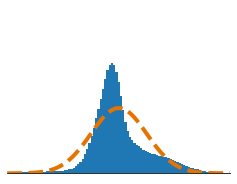

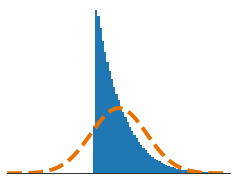

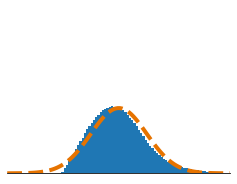

In [41]:

figsize = (4, 3)
fig = plt.figure(figsize=figsize)
xgauss = np.linspace(-4, 4, 100)
hist_x = plt.hist(
    (log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel),
    bins=xgauss);
hist_step = np.diff(hist_x[1])[0]
gaussmax = len(log_E_ravel)/np.sqrt(2*np.pi) * hist_step
ygauss = gaussmax * np.exp(-(xgauss*xgauss)/2)
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2.5*gaussmax])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
print(scipy.stats.skew(log_E_ravel))
print(scipy.stats.kurtosis(log_E_ravel))
plt.gca().axes.get_xaxis().set_visible(False)
fig.savefig(subfolder_str + '_logE_histogram.eps',
    transparent=True, bbox_inches="tight")


fig = plt.figure(figsize=figsize, frameon=False)
plt.hist((indoor_PCEN_ravel - np.mean(indoor_PCEN_ravel)) / np.std(indoor_PCEN_ravel), bins=xgauss);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2.5*gaussmax])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
print(scipy.stats.skew(indoor_PCEN_ravel))
print(scipy.stats.kurtosis(indoor_PCEN_ravel))
plt.gca().axes.get_xaxis().set_visible(False)
fig.savefig(subfolder_str + '_indoor-PCEN_histogram.eps',
    transparent=True, bbox_inches="tight")


fig = plt.figure(figsize=figsize, frameon=False)
plt.hist((outdoor_PCEN_ravel - np.mean(outdoor_PCEN_ravel)) / np.std(outdoor_PCEN_ravel), bins=xgauss);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, 2.5*gaussmax])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
print(scipy.stats.skew(outdoor_PCEN_ravel))
print(scipy.stats.kurtosis(outdoor_PCEN_ravel))
plt.gca().axes.get_xaxis().set_visible(False)
fig.savefig(subfolder_str + '_outdoor-PCEN_histogram.eps',
    transparent=True, bbox_inches="tight")

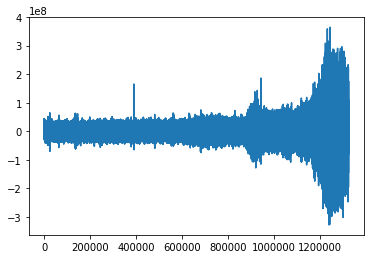

In [34]:
waveform_file = sf.SoundFile(wav_path)
waveform_length = len(waveform_file)
sample_rate = waveform_file.samplerate
waveform_file.seek(0)
waveform = waveform_file.read(waveform_length)
waveform = librosa.resample(
    waveform, sample_rate, outdoor_settings["sr"])
waveform = waveform * (2**31)
plt.plot(waveform)